In [3]:
pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00


In [7]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [9]:
forecast_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

In [10]:
#Dropping unnamed column from  dataframe
forecast_df = forecast_df.drop(columns=['Unnamed: 0'], axis=1)
print(forecast_df)

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [11]:
#Converting Year column to date format
forecast_df['Year'] = pd.to_datetime(forecast_df['Year'], format='%Y')
print(forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704
...         ...          ...        ...                    ...          ...
7864 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878
7865 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628
7866 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425
7867 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597
7868 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [12]:
#Removing all the entries where the Country name is World
forecast_df = forecast_df[forecast_df['Country']!='World']

In [13]:
#Creating a new dataframe group by Year and taking the average of NO2 emission,
#Fertilizer counsumption and Temerature
corr_df = forecast_df.groupby('Year')[['Emission', 'Fertlizer_consumption',
                                          'Temperature']].mean()
print(corr_df)

                Emission  Fertlizer_consumption  Temperature
Year                                                        
1961-01-01  8.489050e+06              14.736211    19.195658
1962-01-01  8.757632e+06              15.680742    19.009852
1963-01-01  9.042756e+06              16.729219    19.045872
1964-01-01  9.387130e+06              17.431719    18.986813
1965-01-01  9.769996e+06              18.166797    18.890422
...                  ...                    ...          ...
2017-01-01  1.840855e+07              52.722031    20.343383
2018-01-01  1.829722e+07              51.806641    20.358923
2019-01-01  1.802809e+07              50.519258    20.509540
2020-01-01  1.808556e+07              53.520234    20.517973
2021-01-01  1.833325e+07              51.773203    20.404902

[61 rows x 3 columns]


In [14]:
#Resetting the index to transfrom Year as column
corr_df = corr_df.reset_index()
#Dropping the Year column for normalizing the data
corr_df_filter = corr_df.drop(columns = ['Year'], axis=1)

In [15]:
#Normalising data using MinMaxScaler and creating a new normalised datafraame
scaler = StandardScaler()
corr_df_norm = pd.DataFrame(scaler.fit_transform(corr_df_filter), columns = corr_df_filter.columns)
print(corr_df_norm)

    Emission  Fertlizer_consumption  Temperature
0  -2.134234              -2.360820    -0.838553
1  -2.041978              -2.277801    -1.227900
2  -1.944039              -2.185647    -1.152421
3  -1.825748              -2.123901    -1.276177
4  -1.694236              -2.059293    -1.478160
..       ...                    ...          ...
56  1.273065               0.977896     1.566445
57  1.234821               0.897439     1.599009
58  1.142378               0.784286     1.914618
59  1.162120               1.048053     1.932289
60  1.247199               0.894500     1.695355

[61 rows x 3 columns]


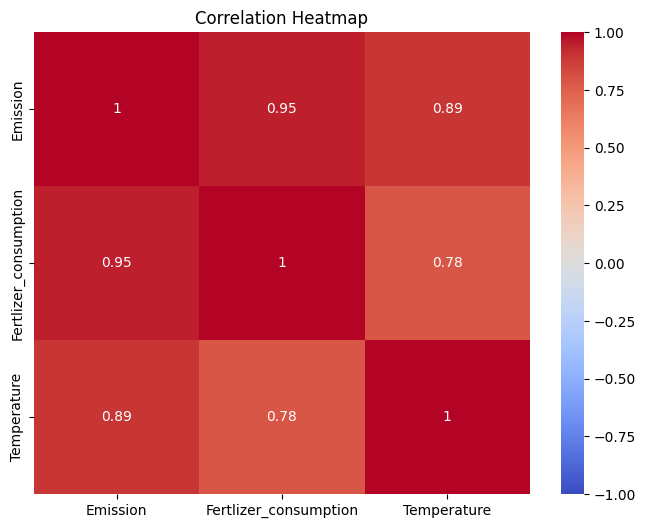

In [16]:
#Creating a correlation heatmap to explain the correlation between variables
corr_matrix = corr_df_norm.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

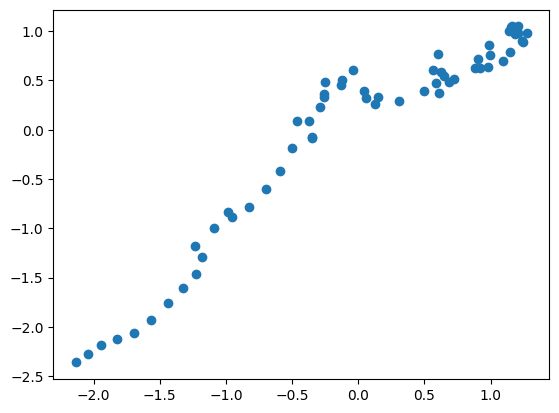

In [17]:
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Fertlizer_consumption'])
plt.show()

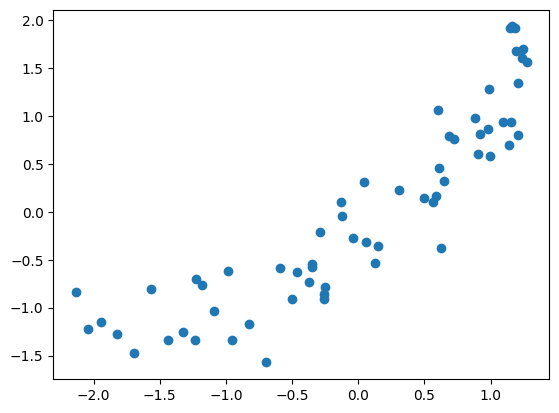

In [18]:
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Temperature'])
plt.show()

In [19]:
cluster_df = forecast_df.copy()

In [23]:
def scale_group(group):
  group[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(group[['Emission', 'Fertlizer_consumption', 'Temperature']])
  return group

In [24]:
cluster_df = cluster_df.groupby('Country').apply(scale_group).reset_index(drop=True)

In [26]:
print(cluster_df)

           Year      Country  Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan -0.712272              -1.337751    -0.917338
1    1962-01-01  Afghanistan -0.751117              -1.337751    -1.135850
2    1963-01-01  Afghanistan -0.676183              -1.337751     0.309998
3    1964-01-01  Afghanistan -0.582949              -1.337751    -1.953138
4    1965-01-01  Afghanistan -0.476538              -1.337751    -1.058171
...         ...          ...       ...                    ...          ...
7803 2017-01-01     Zimbabwe  0.400771              -0.624780     0.032740
7804 2018-01-01     Zimbabwe  0.503282              -1.094862     1.164540
7805 2019-01-01     Zimbabwe  0.403417              -1.094862     2.037056
7806 2020-01-01     Zimbabwe -0.120035              -1.435445     0.958329
7807 2021-01-01     Zimbabwe  0.195951              -1.435445     0.605094

[7808 rows x 5 columns]


In [27]:
cluster_pivot_df = cluster_df.pivot(index='Year', columns='Country', values=['Emission'])

In [28]:
print(cluster_pivot_df)

              Emission                                                    \
Country    Afghanistan   Albania   Algeria    Angola Argentina Australia   
Year                                                                       
1961-01-01   -0.712272 -1.880740 -1.543655 -1.154992 -1.542932 -1.188309   
1962-01-01   -0.751117 -1.863443 -1.508476 -1.142133 -1.598983 -1.067309   
1963-01-01   -0.676183 -1.898035 -1.558351 -1.132957 -1.775032 -0.995242   
1964-01-01   -0.582949 -1.852313 -1.543670 -1.112961 -1.516060 -0.879565   
1965-01-01   -0.476538 -1.661071 -1.435603 -1.092478 -1.206775 -0.825380   
...                ...       ...       ...       ...       ...       ...   
2017-01-01    2.226094  0.396366  1.738142  1.326149  1.907856  0.852372   
2018-01-01    2.083739 -0.100591  1.814894  0.897106  1.762360  0.709590   
2019-01-01    1.766261  0.003037  1.860995  1.369345  2.125832 -0.470699   
2020-01-01    1.655276 -0.432531  1.710426  1.178681  2.348955 -1.369867   
2021-01-01  

In [29]:
reshaped_cluster_pivot_df = cluster_pivot_df.values.reshape(cluster_pivot_df.shape[1], -1)

In [30]:
print(reshaped_cluster_pivot_df)

[[-0.71227186 -1.88073985 -1.54365522 ... -0.69108909 -1.22197405
  -1.12322222]
 [-1.61010305 -1.28084565 -1.5327103  ... -1.59625252 -0.40236186
  -3.3456788 ]
 [-1.20829304 -1.72869438 -1.44050582 ... -1.57847163 -1.35581156
  -1.48220355]
 ...
 [ 0.75973005  1.1076507   2.5656605  ...  1.22495388  2.38950911
  -0.69966207]
 [-1.36821597  0.95953562  1.02010567 ...  1.82268274 -1.02578275
   1.8569505 ]
 [ 1.5734723   0.19675928  1.55788084 ...  1.26919979  1.2758825
   0.19595058]]


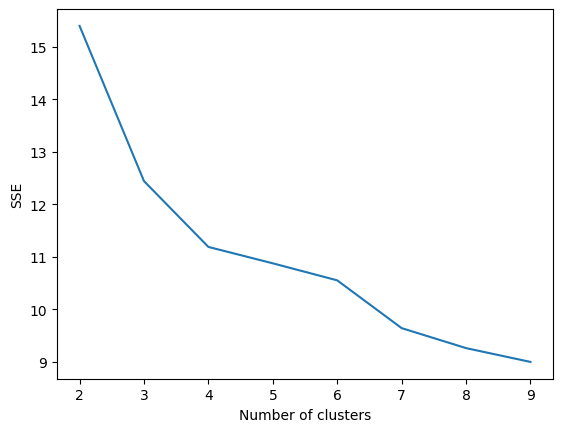

In [31]:
sse = []
for i in range(2,10):
  model = TimeSeriesKMeans(n_clusters=i, metric="dtw", random_state=42)
  model.fit(reshaped_cluster_pivot_df)
  sse.append(model.inertia_)

plt.figure()
plt.plot(range(2,10), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


In [32]:

for i in range(2,10):
  model = TimeSeriesKMeans(n_clusters=i, metric="dtw", random_state=42)
  labels = model.fit_predict(reshaped_cluster_pivot_df)
  s_avg = silhouette_score(reshaped_cluster_pivot_df, labels)
  print("cluster :", i)
  print("score :", s_avg)


cluster : 2
score : 0.26488908810588646
cluster : 3
score : 0.15070759805363967
cluster : 4
score : 0.08102343152606191
cluster : 5
score : 0.0726530457424158
cluster : 6
score : 0.056478945411170434
cluster : 7
score : 0.03152320671714038
cluster : 8
score : 0.0005478870882898697
cluster : 9
score : -0.01246752868948017


In [33]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
labels = model.fit_predict(reshaped_cluster_pivot_df)

# Create a dataframe with cluster labels
country_labels = pd.DataFrame({'Country': cluster_pivot_df.columns.levels[1], 'Cluster': labels})

In [34]:
cluster_df = pd.merge(cluster_df, country_labels, on=['Country'])
print(cluster_df)

           Year      Country  Emission  Fertlizer_consumption  Temperature  \
0    1961-01-01  Afghanistan -0.712272              -1.337751    -0.917338   
1    1962-01-01  Afghanistan -0.751117              -1.337751    -1.135850   
2    1963-01-01  Afghanistan -0.676183              -1.337751     0.309998   
3    1964-01-01  Afghanistan -0.582949              -1.337751    -1.953138   
4    1965-01-01  Afghanistan -0.476538              -1.337751    -1.058171   
...         ...          ...       ...                    ...          ...   
7803 2017-01-01     Zimbabwe  0.400771              -0.624780     0.032740   
7804 2018-01-01     Zimbabwe  0.503282              -1.094862     1.164540   
7805 2019-01-01     Zimbabwe  0.403417              -1.094862     2.037056   
7806 2020-01-01     Zimbabwe -0.120035              -1.435445     0.958329   
7807 2021-01-01     Zimbabwe  0.195951              -1.435445     0.605094   

      Cluster  
0           1  
1           1  
2           1  

In [270]:
cluster_grouped_df = cluster_df.groupby(['Country', 'Cluster'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()

In [271]:
print(cluster_grouped_df)

                         Emission  Fertlizer_consumption   Temperature
Country     Cluster                                                   
Afghanistan 1       -4.513694e-16          -9.737202e-17 -2.198606e-15
Albania     1        5.532915e-16          -4.791249e-16  2.635415e-15
Algeria     1       -8.736181e-17           2.293248e-16 -2.431570e-15
Angola      1       -1.674435e-16          -1.419629e-16 -7.243750e-15
Argentina   1        4.295289e-16           1.601633e-16 -1.401429e-15
...                           ...                    ...           ...
Venezuela   0       -2.329648e-16           1.565232e-16  2.545323e-15
Vietnam     0       -1.019221e-16           5.824121e-17  9.344074e-15
Yemen       0       -7.680559e-16           1.515181e-16  6.730500e-15
Zambia      0       -1.055622e-16           2.184045e-17  2.480711e-15
Zimbabwe    0        8.099168e-17           5.423712e-16 -2.822879e-15

[128 rows x 3 columns]


In [272]:
cluster_grouped_df = cluster_grouped_df.reset_index()

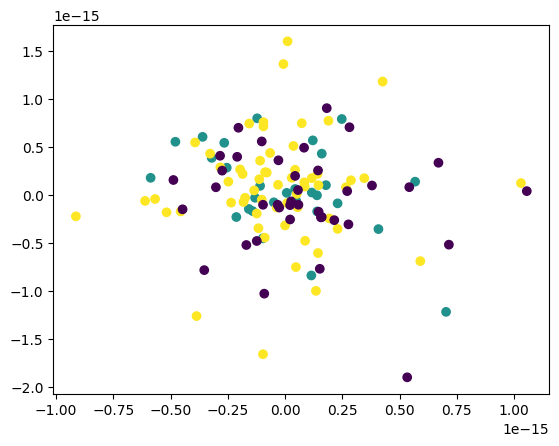

In [273]:
plt.figure()
plt.scatter(x=cluster_grouped_df['Fertlizer_consumption'], y=cluster_grouped_df['Emission'], c=cluster_grouped_df["Cluster"])

In [274]:
cluster0_df = cluster_df[cluster_df['Cluster']==0]
cluster1_df = cluster_df[cluster_df['Cluster']==1]
cluster2_df = cluster_df[cluster_df['Cluster']==2]


In [275]:
print(cluster0_df['Country'].unique())

['Costa Rica' 'Papua New Guinea' 'Paraguay' 'Peru' 'Philippines' 'Poland'
 'Portugal' 'Qatar' 'Romania' 'Rwanda' 'Saint Vincent and the Grenadines'
 'Saudi Arabia' 'Senegal' 'Sierra Leone' 'Somalia' 'South Africa'
 'South Korea' 'Spain' 'Sri Lanka' 'Suriname' 'Sweden' 'Switzerland'
 'Syria' 'Tanzania' 'Thailand' 'Togo' 'Trinidad and Tobago' 'Tunisia'
 'Turkey' 'Uganda' 'United Arab Emirates' 'United Kingdom' 'United States'
 'Uruguay' 'Venezuela' 'Vietnam' 'Yemen' 'Zambia' 'Zimbabwe']


In [276]:
cluster0_grouped_df = cluster0_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster1_grouped_df = cluster1_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster2_grouped_df = cluster2_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()


In [277]:
print(cluster0_grouped_df)

            Emission  Fertlizer_consumption  Temperature
Year                                                    
1961-01-01 -1.519664              -1.338489    -0.636444
1962-01-01 -1.460362              -1.323370    -1.099326
1963-01-01 -1.381312              -1.308557    -1.044890
1964-01-01 -1.294939              -1.244186    -1.120886
1965-01-01 -1.216885              -1.192831    -1.239507
...              ...                    ...          ...
2017-01-01  0.838850               0.940320     1.291291
2018-01-01  0.796221               0.812062     1.075466
2019-01-01  0.858048               0.796356     1.528524
2020-01-01  0.897592               0.951478     1.583349
2021-01-01  0.931033               0.714135     1.167171

[61 rows x 3 columns]


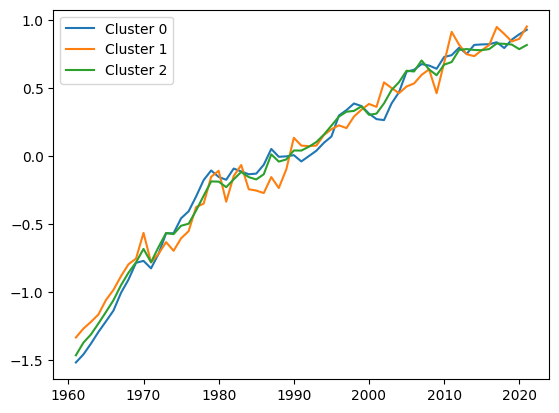

In [278]:
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Emission'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Emission'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Emission'], label='Cluster 2')
plt.legend()
plt.show()

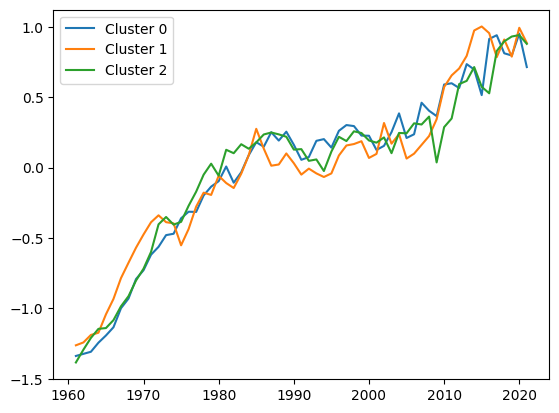

In [279]:
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Fertlizer_consumption'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Fertlizer_consumption'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Fertlizer_consumption'], label='Cluster 2')
plt.legend()
plt.show()

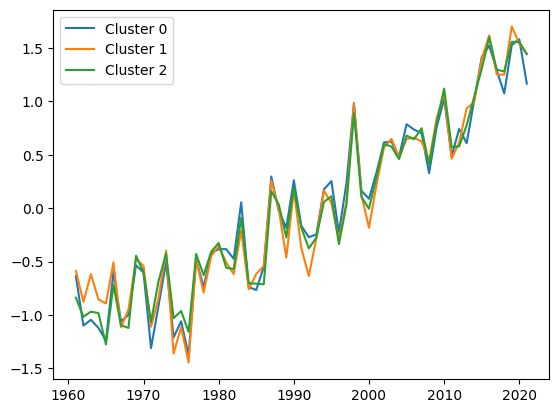

In [280]:
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Temperature'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Temperature'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Temperature'], label='Cluster 2')
plt.legend()
plt.show()

In [ ]:
print(cluster2_df['Country'].unique())